# SAM: Multiple Prompting & Blending of Masks

## Setups

### Logger Setup

In [1]:
import logging

In [2]:
# define a formatter to display the messages to console (standard output)
console_formatter = logging.Formatter('%(message)s')
console_handler = logging.StreamHandler()
console_handler.setFormatter(console_formatter)

In [3]:
# define a logger for this notebook and attach the console handler
logger = logging.getLogger('SAM-Masks-Blender')
logger.handlers.clear()
logger.propagate = False
logger.addHandler(console_handler)

In [4]:
# set an appropriate level of logging for this notebook
logger.setLevel(logging.DEBUG)

### Mount GCS Bucket

References:
1. [Mount a Cloud Storage bucket using Cloud Storage FUSE](https://cloud.google.com/storage/docs/gcsfuse-quickstart-mount-bucket)
2. [Snippets: Saving Data to Google Cloud Storage](https://colab.research.google.com/notebooks/snippets/gcs.ipynb)
3. [Connect Colab to GCS Bucket Using gcsfuse](https://pub.towardsai.net/connect-colab-to-gcs-bucket-using-gcsfuse-29f4f844d074)

**Authentication**

This step authenticates the user in order to access Google Storage Bucket using an authenticated account.

In [5]:
from google.colab import auth
auth.authenticate_user()

**Install Cloud Storage FUSE**

1. Add the Cloud Storage FUSE distribution URL as a package source:

In [6]:
# check if gcsfuse.list file exists at the path it normally resides
!ls /etc/apt/sources.list.d

archive_uri-https_cloud_r-project_org_bin_linux_ubuntu-jammy.list
c2d4u_team-ubuntu-c2d4u4_0_-jammy.list
cuda-ubuntu2204-x86_64.list
deadsnakes-ubuntu-ppa-jammy.list
graphics-drivers-ubuntu-ppa-jammy.list
ubuntugis-ubuntu-ppa-jammy.list


In [7]:
# open gcsfuse.list file and show its contents
!cat /etc/apt/sources.list.d/gcsfuse.list

cat: /etc/apt/sources.list.d/gcsfuse.list: No such file or directory


In [8]:
# add Cloud Storage FUSE distribution URL as a package source
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list

deb https://packages.cloud.google.com/apt gcsfuse-jammy main


In [9]:
# open gcsfuse.list file and show its contents
!cat /etc/apt/sources.list.d/gcsfuse.list

deb https://packages.cloud.google.com/apt gcsfuse-jammy main


2. Import the Google Cloud APT repository public key and add it to your list of keys:

In [10]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  21984      0 --:--:-- --:--:-- --:--:-- 22158
OK


3. Updates the list of available packages and install gcsfuse:

In [11]:
!apt -qq update && apt -qq install gcsfuse

24 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 5,415 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../gcsfuse_1.4.0_amd64.deb ...
Unpacking gcsfuse (1.4.0) ...
Setting up gcsfuse (1.4.0) ...


In [12]:
# check if gcsfuse is installed
!gcsfuse -v

gcsfuse version 1.4.0 (Go version go1.21.5)


**Mount Bucket on Colab Disk**

Initialize bucket name and the folder on Colab on which the bucket will be mounted

In [13]:
BUCKET_NAME = 'rs_storage_open'
BUCKET_MOUNT_DIR = f"/mnt/gs/{BUCKET_NAME}"

Create a directory to mount the storage bucket to

In [14]:
!mkdir -p {BUCKET_MOUNT_DIR}

In [15]:
!ls -l /mnt/gs

total 4
drwxr-xr-x 2 root root 4096 Jan  9 06:24 rs_storage_open


Mount your storage bucket using the gcsfuse command:

In [16]:
!gcsfuse --implicit-dirs {BUCKET_NAME} {BUCKET_MOUNT_DIR}

{"time":"09/01/2024 06:24:28.061357","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /mnt/gs/rs_storage_open\n"}


In [17]:
!ls -l {BUCKET_MOUNT_DIR}

total 9
drwxr-xr-x 1 root root    0 Jan  9 06:24 benthic_datasets
-rw-r--r-- 1 root root 8514 Nov 14 13:31 README.md


### Mount Google Drive

In [18]:
import os
from google.colab import drive

In [19]:
DRIVE_MOUNT_DIR = '/content/drive'
drive.mount(DRIVE_MOUNT_DIR, force_remount=True)

Mounted at /content/drive


### Directory Setup

Local Root Directory

In [20]:
# local root directory for this notebook
LOCAL_ROOT_DIR = '/content'

Bucket Mount Directory

In [21]:
# Root folder for dataset
logger.info(f"Root directory for dataset: {BUCKET_MOUNT_DIR}")

Root directory for dataset: /mnt/gs/rs_storage_open


Project Root Directory

In [22]:
# Root folder in Google Drive for this project
PROJECT_ROOT_DIR = os.path.join(DRIVE_MOUNT_DIR, 'MyDrive', '20231114-FruitPunch-AI-for-Coral-Reefs-2')
logger.info(f"Root directory for project in Google Drive: {PROJECT_ROOT_DIR}")

Root directory for project in Google Drive: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2


### Custom Libraries & Weights

In [23]:
import sys
import shutil

In [24]:
# add the path where point label aware superpixels and custom packags is located
sys.path.append(os.path.join(PROJECT_ROOT_DIR, 'packages'))

In [25]:
WEIGHTS_PATH = '/content/weights'
WEIGHTS_FILE = 'sam_vit_h_4b8939.pth'
!mkdir {WEIGHTS_PATH}
!wget https://dl.fbaipublicfiles.com/segment_anything/{WEIGHTS_FILE} -P {WEIGHTS_PATH}

--2024-01-09 06:24:49--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/content/weights/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   244MB/s    in 10s     

2024-01-09 06:24:59 (245 MB/s) - ‘/content/weights/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



### Dependencies

In [26]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.5 MB/s eta 0:00:00


In [27]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cq7d3f6n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cq7d3f6n
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=aa9cbf67675a2e6e53a18584a20dcfa61d0b18d1ef0e1350244cc6275f89440f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9du0baor/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [28]:
import cv2
import pandas as pd

from pathlib import Path

In [29]:
from labelmate.loader import LabelPropDataLoader
from labelmate.visualizer import visualize_output
from labelmate.evaluator import LabelPropEvaluator

In [30]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [31]:
custom_modules = ['labelmate.loader', 'labelmate.visualizer',
                  'labelmate.evaluator',
                  ]
for module_name in custom_modules:
    logging.getLogger(module_name).setLevel(logging.INFO)

## Input Variables

In [32]:
# Path to folder that contains images and dense masks
DATA_ROOT_DIR = os.path.join(BUCKET_MOUNT_DIR, 'benthic_datasets', 'mask_labels', 'reef_support')
logger.info(f"Dataset (images and masks) will be accessed from: {DATA_ROOT_DIR}")

Dataset (images and masks) will be accessed from: /mnt/gs/rs_storage_open/benthic_datasets/mask_labels/reef_support


In [33]:
# Path to permanently store input images, input sparse masks in image format and output from SAM
RESULTS_UPLOAD_PATH = os.path.join(PROJECT_ROOT_DIR, 'findings', 'SAM-POC-EXP-1')
logger.info(f"Results obtained will be saved to: {RESULTS_UPLOAD_PATH}")

Results obtained will be saved to: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-POC-EXP-1


In [34]:
# Path to the csv that contains image level summary for Reef Support dataset
REEF_SUPPORT_MANIFEST_PATH = os.path.join(PROJECT_ROOT_DIR, 'data', 'MANIFEST_REEF_SUPPORT.csv')
logger.info(f"Dataset manifest will be accessed from: {REEF_SUPPORT_MANIFEST_PATH}")

Dataset manifest will be accessed from: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/data/MANIFEST_REEF_SUPPORT.csv


In [35]:
# Combined Point Labels data from Reef Support Dense Masks and Seaview Point Labels with results of label comparison exercise
REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH = os.path.join(PROJECT_ROOT_DIR, 'data', 'DATA-REEF-SUPPORT-POINT-LABELS-v1.csv')
logger.info(f"Point labels data will be loaded from: {REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH}")

Point labels data will be loaded from: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/data/DATA-REEF-SUPPORT-POINT-LABELS-v1.csv


## Dataset Preparation

### Read Manifest & Point Labels

In [36]:
manifest_df = pd.read_csv(REEF_SUPPORT_MANIFEST_PATH, header='infer')
point_labels_df = pd.read_csv(REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH, header='infer')

In [37]:
point_labels_df['class_name'] = point_labels_df.reef_support_class_name
point_labels_df['class_label'] = point_labels_df.reef_support_class_label

In [38]:
if point_labels_df.quadratid.dtype != object:
    point_labels_df = \
        point_labels_df.astype({'quadratid': str})
    print("Changed Quadrat ID to object data type")
else:
    print("Quadrat ID is already in object data type")

Changed Quadrat ID to object data type


In [39]:
manifest_df.sample(2)

,quadratid,region,folder,mask_patches,mask_stitched,height,width,mask_height,mask_width,other_pixels,...,point_labels_count,comparison_status,class_label_comparison,points_mismatch_count,hard_coral_mismatch_count,soft_coral_mismatch_count,points_mismatch_percent,hard_coral_mismatch_percent,soft_coral_mismatch_percent,image_file_name
3273,G0088496,PROVIDENCIA,TETES_PROVIDENCIA,20,1,3888,5184,3888,5184,52024053,...,100,SUCCESS,Match,0,0,0,0.0,0.0,0.0,G0088496.JPG
2080,44009055601,PAC_USA,SEAVIEW_PAC_USA,1,1,1608,1608,1608,1608,7188198,...,50,SUCCESS,Mismatch,3,2,0,6.0,4.0,0.0,44009055601.jpg


In [40]:
point_labels_df.sample(2)

,quadratid,y,x,label_name,label,func_group,method,data_set,region,seaview_class_name,seaview_class_label,reef_support_class_name,reef_support_class_label,class_label_comparison,class_name,class_label
108677,38018231701,856,474,Sponge,SINV_SPO_M,Other Invertebrates,random,test,PAC_USA,Others,0,Hard Coral,1,Mismatch,Hard Coral,1
10197,20024005801,951,763,Millepora,Mille,Other Invertebrates,random,test,ATL,Others,0,Hard Coral,1,Mismatch,Hard Coral,1


### Sample Selection

In [41]:
quadrat_ids = ['32028198201', ]

### Dataset Data Frame

In [42]:
samples = []

for quadrat_id in quadrat_ids:
    image_file_name = manifest_df.query(f"quadratid == '{quadrat_id}'").image_file_name.item()
    folder = manifest_df.query(f"quadratid == '{quadrat_id}'").folder.item()
    region = manifest_df.query(f"quadratid == '{quadrat_id}'").region.item()

    point_labels_source = 'SPARSE'
    point_labels_count = manifest_df.query(f"quadratid == '{quadrat_id}'").point_labels_count.item()

    sample = dict(
        sample_id=quadrat_id,
        dataset_name=folder,
        region=region,
        image_path=os.path.join(DATA_ROOT_DIR, folder, 'images', image_file_name),
        mask_path=os.path.join(DATA_ROOT_DIR, folder, 'masks_stitched', f"{quadrat_id}_mask.png"),
        point_labels_source=point_labels_source,
        point_labels_count=point_labels_count,
    )
    samples.append(sample)

dataset_df = pd.DataFrame(samples)

In [43]:
dataset_df

,sample_id,dataset_name,region,image_path,mask_path,point_labels_source,point_labels_count
0,32028198201,SEAVIEW_IDN_PHL,PAC_IDN_PHL,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,/mnt/gs/rs_storage_open/benthic_datasets/mask_...,SPARSE,100


### Dataloader Setup

In [44]:
label_prop_data = \
    LabelPropDataLoader(
        experiment_name='SAM-POC-EXP-1',
        dataset=dataset_df.copy(),
        point_labels=point_labels_df.copy(),
        num_classes=3,
        working_folder=Path('/content/sam-blender'),
        transforms=None,
        )

In [45]:
label_prop_data.sub_folders

{'images': PosixPath('/content/sam-blender/images'),
 'labels': PosixPath('/content/sam-blender/labels'),
 'masks': PosixPath('/content/sam-blender/masks'),
 'predictions': PosixPath('/content/sam-blender/predictions')}

In [46]:
label_prop_data.delete_sub_folders()

In [47]:
label_prop_data.create_sub_folders()

In [48]:
label_prop_data.prepare_input_data()

  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
label_prop_data[0]

{'experiment_name': 'SAM-POC-EXP-1',
 'sample_id': '32028198201',
 'image_path': PosixPath('/content/sam-blender/images/32028198201.png'),
 'mask_path': PosixPath('/content/sam-blender/masks/32028198201.png'),
 'prediction_path': PosixPath('/content/sam-blender/predictions/32028198201.png'),
 'point_labels':           quadratid    y    x                  label_name       label  \
 176470  32028198201  194   78        EAM: Dead Hard Coral     EAM_DHC   
 176471  32028198201  113   97        EAM: Dead Hard Coral     EAM_DHC   
 176472  32028198201  205  160      Epilithic Algal Matrix         Unc   
 176473  32028198201  149  209      Epilithic Algal Matrix         Unc   
 176474  32028198201  224   75     Hydroids feathery types    SINV_HYD   
 ...             ...  ...  ...                         ...         ...   
 176565  32028198201  869  692  MASE: Large Rounded Polyps  MASE_LRG_O   
 176566  32028198201  948  956      Epilithic Algal Matrix         Unc   
 176567  32028198201  880

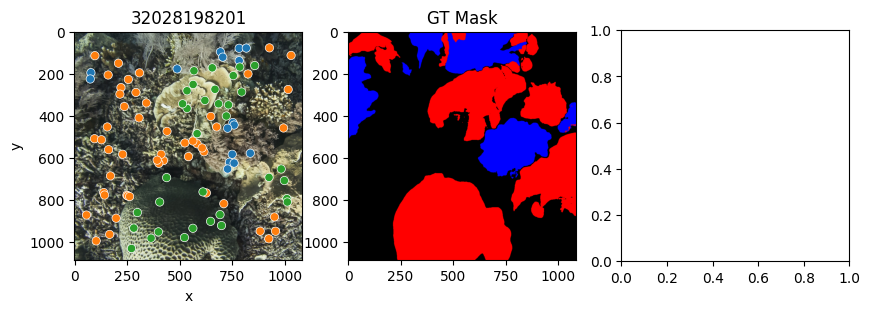

In [50]:
index = 0
visualize_output(**label_prop_data[index])

## Patchifier

### Class Definition

In [51]:
import os
import cv2
import numpy as np
from pathlib import Path

class Patchifier():
    def __init__(
            self,
            sample_id,
            image_path,
            mask_path,
            point_labels,
            patch_path,
            patch_height=256,
            patch_width=256,
            step_size=256
            ):
        self.sample_id = sample_id
        self.image_path = image_path
        self.mask_path = mask_path
        self.point_labels = point_labels

        self.patch_path = patch_path
        self.patch_height = patch_height
        self.patch_width = patch_width
        self.step_size = step_size

        self.patch_ids = []
        self.patch_images = []
        self.patch_masks = []
        self.patch_point_labels = []

    def read_image(self, image_path):
        # read image from specified path
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def read_mask(self, mask_path):
        # read image from specified path
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        return mask

    def get_patches_origins(self, image_shape):
        image_height = image_shape[0]
        image_width = image_shape[1]
        patches_h_indices = [i * self.step_size for i in range(int(np.ceil(image_height / self.step_size)))]
        patches_w_indices = [i * self.step_size for i in range(int(np.ceil(image_width / self.step_size)))]
        patches_origins_meshgrid = np.meshgrid(patches_h_indices, patches_w_indices, indexing='ij')
        patches_origins = [
            dict(h=coords[0], w=coords[1])
            for coords in zip(patches_origins_meshgrid[0].reshape(-1), patches_origins_meshgrid[1].reshape(-1))
            ]
        logger.debug(f"Patches H Indices: {patches_h_indices}")
        logger.debug(f"Patches W Indices: {patches_w_indices}")
        logger.debug(f"Patches Origins: {patches_origins}")
        return patches_origins

    def create_patches(self):
        image = self.read_image(str(self.image_path.resolve()))
        mask = self.read_mask(str(self.mask_path.resolve()))
        patches_origins = self.get_patches_origins(image.shape)
        patch_id = 1
        for patch_origin in patches_origins:
            # extract image patch from given origin
            image_patch = \
                image[
                    patch_origin['h'] : patch_origin['h'] + self.patch_height,
                    patch_origin['w'] : patch_origin['w'] + self.patch_width,
                    :
                    ]
            image_patch_write_path = Path.joinpath(self.patch_path, 'images', f"{self.sample_id}-{patch_id}.png")
            image_patch_write_status = \
                cv2.imwrite(
                    str(image_patch_write_path.resolve()),
                    cv2.cvtColor(image_patch, cv2.COLOR_RGB2BGR),
                    )

            # extract mask patch from given origin
            mask_patch = \
                mask[
                    patch_origin['h'] : patch_origin['h'] + self.patch_height,
                    patch_origin['w'] : patch_origin['w'] + self.patch_width,
                    ]
            mask_patch_write_path = Path.joinpath(self.patch_path, 'masks', f"{self.sample_id}-{patch_id}.png")
            mask_patch_write_status = cv2.imwrite(str(mask_patch_write_path.resolve()), mask_patch)

            # extract point labels for patch
            point_labels_patch = \
                self.point_labels\
                    .query(f"quadratid == '{self.sample_id}'")\
                    .query(f"y >= {patch_origin['h']}")\
                    .query(f"y < {patch_origin['h'] + self.patch_height}")\
                    .query(f"x >= {patch_origin['w']}")\
                    .query(f"x < {patch_origin['w'] + self.patch_width}")\
                    .copy()

            point_labels_patch['y'] = point_labels_patch['y'] - patch_origin['h']
            point_labels_patch['x'] = point_labels_patch['x'] - patch_origin['w']

            self.patch_ids.append(patch_id)
            self.patch_images.append(image_patch)
            self.patch_masks.append(mask_patch)
            self.patch_point_labels.append(point_labels_patch)

            patch_id += 1

### Test Patchifier

In [52]:
os.makedirs('/content/sam-patches/images', exist_ok=True)
os.makedirs('/content/sam-patches/masks', exist_ok=True)

In [53]:
patchifier = \
    Patchifier(
        sample_id=label_prop_data[0]['sample_id'],
        image_path=label_prop_data[0]['image_path'],
        mask_path=label_prop_data[0]['mask_path'],
        point_labels=label_prop_data[0]['point_labels'],
        patch_path=Path('/content/sam-patches'),
        patch_height=256,
        patch_width=256,
        step_size=256
    )

In [54]:
patchifier.create_patches()

Patches H Indices: [0, 256, 512, 768, 1024]
Patches W Indices: [0, 256, 512, 768, 1024]
Patches Origins: [{'h': 0, 'w': 0}, {'h': 0, 'w': 256}, {'h': 0, 'w': 512}, {'h': 0, 'w': 768}, {'h': 0, 'w': 1024}, {'h': 256, 'w': 0}, {'h': 256, 'w': 256}, {'h': 256, 'w': 512}, {'h': 256, 'w': 768}, {'h': 256, 'w': 1024}, {'h': 512, 'w': 0}, {'h': 512, 'w': 256}, {'h': 512, 'w': 512}, {'h': 512, 'w': 768}, {'h': 512, 'w': 1024}, {'h': 768, 'w': 0}, {'h': 768, 'w': 256}, {'h': 768, 'w': 512}, {'h': 768, 'w': 768}, {'h': 768, 'w': 1024}, {'h': 1024, 'w': 0}, {'h': 1024, 'w': 256}, {'h': 1024, 'w': 512}, {'h': 1024, 'w': 768}, {'h': 1024, 'w': 1024}]


### Check Results

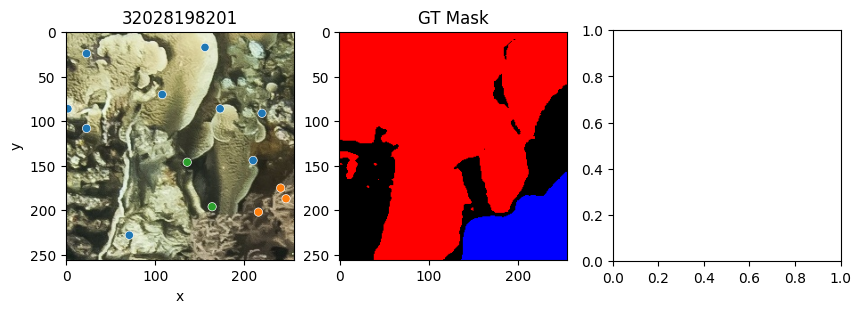

In [55]:
patch_id = 8
visualize_output(
    sample_id=patchifier.sample_id,
    image_path=Path(f'/content/sam-patches/images/32028198201-{patch_id}.png'),
    mask_path=Path(f'/content/sam-patches/masks/32028198201-{patch_id}.png'),
    prediction_path=Path(f'/content/sam-patches/masks/32028198201-{patch_id}-.png'),
    point_labels=patchifier.patch_point_labels[patch_id-1].copy(),
    experiment_name=None,
    )

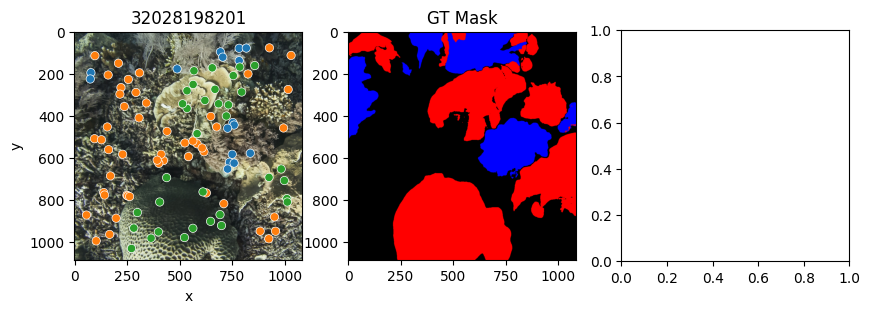

In [56]:
index = 0
visualize_output(**label_prop_data[index])

In [57]:
patchifier.patch_point_labels[patch_id-1]

,quadratid,y,x,label_name,label,func_group,method,data_set,region,seaview_class_name,seaview_class_label,reef_support_class_name,reef_support_class_label,class_label_comparison,class_name,class_label
176498,32028198201,108,23,TFP: Visible Round Corallites,TFP_RND_Al,Hard Coral,random,train,PAC_IDN_PHL,Hard Coral,1,Hard Coral,1,Match,Hard Coral,1
176499,32028198201,86,2,TFP: Visible Round Corallites,TFP_RND_Al,Hard Coral,random,train,PAC_IDN_PHL,Hard Coral,1,Hard Coral,1,Match,Hard Coral,1
176500,32028198201,70,108,TFP: Visible Round Corallites,TFP_RND_Al,Hard Coral,random,train,PAC_IDN_PHL,Hard Coral,1,Hard Coral,1,Match,Hard Coral,1
176501,32028198201,24,23,TFP: Visible Round Corallites,TFP_RND_Al,Hard Coral,random,train,PAC_IDN_PHL,Hard Coral,1,Hard Coral,1,Match,Hard Coral,1
176502,32028198201,91,220,EAM: Dead Hard Coral,EAM_DHC,Algae,random,train,PAC_IDN_PHL,Others,0,Hard Coral,1,Mismatch,Hard Coral,1
176503,32028198201,86,173,TFP: Visible Round Corallites,TFP_RND_Al,Hard Coral,random,train,PAC_IDN_PHL,Hard Coral,1,Hard Coral,1,Match,Hard Coral,1
176504,32028198201,175,241,Other soft-corals no common Alcyoniidae and er...,SINV_SFC_O,Soft Coral,random,train,PAC_IDN_PHL,Soft Coral,2,Soft Coral,2,Match,Soft Coral,2
176505,32028198201,146,136,Epilithic Algal Matrix,Unc,Algae,random,train,PAC_IDN_PHL,Others,0,Others,0,Match,Others,0
176506,32028198201,187,247,Other soft-corals no common Alcyoniidae and er...,SINV_SFC_O,Soft Coral,random,train,PAC_IDN_PHL,Soft Coral,2,Soft Coral,2,Match,Soft Coral,2
176508,32028198201,144,210,MASE: Small or Invis Polyps,MASE_SML_O,Hard Coral,random,train,PAC_IDN_PHL,Hard Coral,1,Hard Coral,1,Match,Hard Coral,1


## SAM Prompting

In [2]:
import torch
import matplotlib.pyplot as plt

True

### Load SAM

In [59]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [60]:
sam = \
    sam_model_registry[MODEL_TYPE](
        checkpoint=os.path.join(WEIGHTS_PATH, WEIGHTS_FILE)
        ).to(device=DEVICE)

In [61]:
patchifier.patch_point_labels[patch_id-1].class_label.sort_values().unique()

array([0, 1, 2])

### Define Point Prompts

In [62]:
patch_id = 8

prompts = []

# build prompt only for those class labels present in the data
for positive_class_label in patchifier.patch_point_labels[patch_id-1].class_label.sort_values().unique():
    point_coords = []
    point_labels = []

    # build points based prompting parameters using positive and negative labels
    for index, point_label in patchifier.patch_point_labels[patch_id-1].iterrows():
        point_coords.append([point_label['x'], point_label['y']])
        if point_label.class_label == positive_class_label:
            point_labels.append(1)
        else:
            point_labels.append(0)

    logger.debug(f"Positive Class Label: {positive_class_label}")
    logger.debug(f"Points Coordinates (x,y): {point_coords}")
    logger.debug(f"Point Labels: {point_labels}")

    # add positive class label and points details as a prompt
    prompt = dict(class_label=positive_class_label, point_coords=point_coords, point_labels=point_labels)
    prompts.append(prompt)

Positive Class Label: 0
Points Coordinates (x,y): [[23, 108], [2, 86], [108, 70], [23, 24], [220, 91], [173, 86], [241, 175], [136, 146], [247, 187], [210, 144], [156, 17], [71, 228], [164, 196], [216, 202]]
Point Labels: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Positive Class Label: 1
Points Coordinates (x,y): [[23, 108], [2, 86], [108, 70], [23, 24], [220, 91], [173, 86], [241, 175], [136, 146], [247, 187], [210, 144], [156, 17], [71, 228], [164, 196], [216, 202]]
Point Labels: [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
Positive Class Label: 2
Points Coordinates (x,y): [[23, 108], [2, 86], [108, 70], [23, 24], [220, 91], [173, 86], [241, 175], [136, 146], [247, 187], [210, 144], [156, 17], [71, 228], [164, 196], [216, 202]]
Point Labels: [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]


### Run SAM

In [63]:
mask_predictor = SamPredictor(sam)

In [71]:
mask_predictor.set_image(patchifier.patch_images[patch_id-1])

In [72]:
for index in range(len(prompts)):
    sam_masks = sam_scores = sam_logits = None

    sam_masks, sam_scores, sam_logits = \
        mask_predictor.predict(
            point_coords=np.array(prompts[index]['point_coords']),
            point_labels=np.array(prompts[index]['point_labels']),
            multimask_output=False,
            )

    prompts[index]['mask'] = sam_masks[0]
    prompts[index]['score'] = sam_scores[0]
    prompts[index]['logits'] = sam_logits[0]
    prompts[index]['logits_min'] = np.min(sam_logits[0])

### Check Masks & Logits

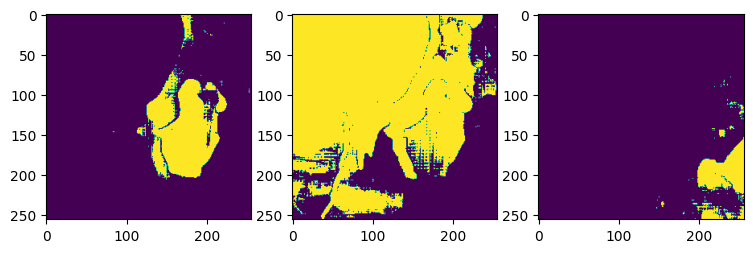

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=len(prompts), figsize=(9, 3))
for index in range(len(prompts)):
    ax[index].imshow(prompts[index]['mask'])
plt.show()

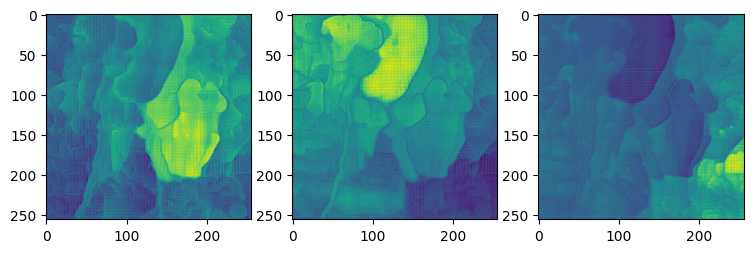

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=len(prompts), figsize=(9, 3))
for index in range(len(prompts)):
    ax[index].imshow(prompts[index]['logits'])
plt.show()

### Blending of Logits

In [75]:
sam_logits_stacked = np.array([prompt['logits'] for prompt in prompts])
sam_logits_stacked.shape

(3, 256, 256)

In [76]:
sam_logits_max = np.argmax(sam_logits_stacked, axis=0)
sam_logits_max.shape

(256, 256)

In [77]:
for index in range(len(prompts)):
    logits_blended = prompts[index]['logits'][:,:]
    pull_down_indices = np.where(sam_logits_max != index, True, False)
    logits_blended[pull_down_indices] = prompts[index]['logits_min']
    prompts[index]['logits_blended'] = logits_blended[:,:]

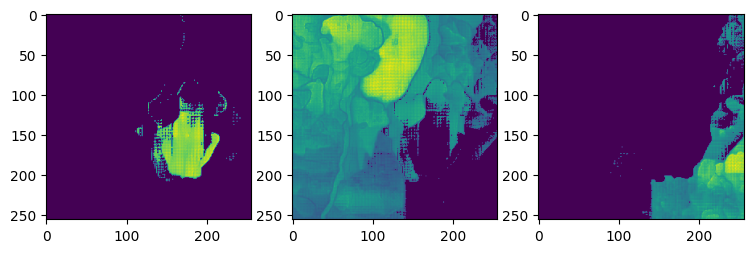

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=len(prompts), figsize=(9, 3))
for index in range(len(prompts)):
    ax[index].imshow(prompts[index]['logits_blended'])
plt.show()

### Blending of Masks

In [88]:
for index in range(len(prompts)):
    post_processed_mask = \
        sam.postprocess_masks(
            masks=torch.from_numpy(prompts[index]['logits_blended']).unsqueeze(dim=0).unsqueeze(dim=0),
            input_size=mask_predictor.input_size,
            original_size=mask_predictor.original_size,
            )

    prompts[index]['mask_blended'] = post_processed_mask.squeeze().numpy() > mask_predictor.model.mask_threshold

In [89]:
sam_masks_stacked = np.array([prompt['mask_blended'] * prompt['class_label'] for prompt in prompts])
sam_masks_stacked.shape

(3, 256, 256)

In [90]:
mask_blended = np.sum(sam_masks_stacked, axis=0)

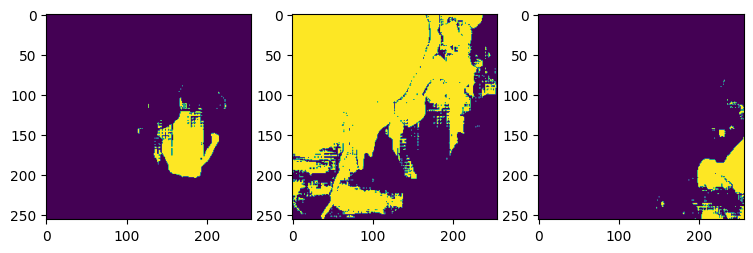

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=len(prompts), figsize=(9, 3))
for index in range(len(prompts)):
    ax[index].imshow(prompts[index]['mask_blended'])
plt.show()

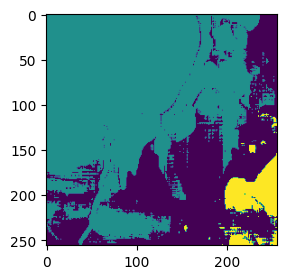

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
ax.imshow(mask_blended)
plt.show()

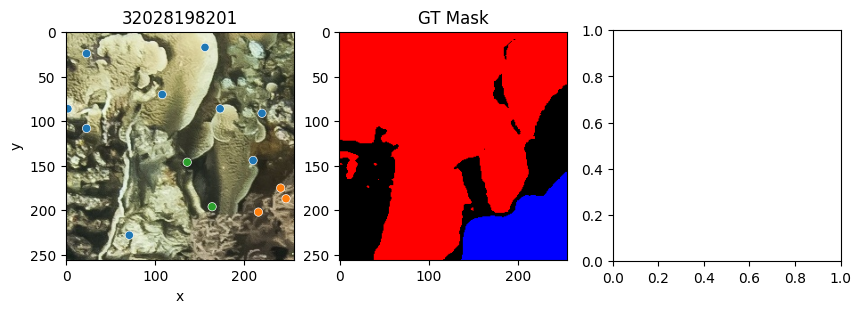

In [84]:
patch_id = 8
visualize_output(
    sample_id=patchifier.sample_id,
    image_path=Path(f'/content/sam-patches/images/32028198201-{patch_id}.png'),
    mask_path=Path(f'/content/sam-patches/masks/32028198201-{patch_id}.png'),
    prediction_path=Path(f'/content/sam-patches/masks/32028198201-{patch_id}-.png'),
    point_labels=patchifier.patch_point_labels[patch_id-1].copy(),
    experiment_name=None,
    )

## Playground

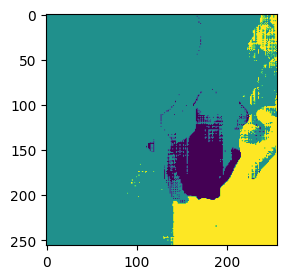

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
ax.imshow(np.argmax(sam_logits_stacked, axis=0))
plt.show()

In [87]:
mask_predictor.model.mask_threshold

0.0

In [ ]:
np.min(sam_logits[0])

-7.44652

In [ ]:
a = np.array([[1, 0, 0], [0, 1, 1], [0, 0, 0]])
a

array([[1, 0, 0],
       [0, 1, 1],
       [0, 0, 0]])

In [ ]:
b = np.array([[0, 1, 1], [1, 0, 0], [1, 1, 1]])
b

array([[0, 1, 1],
       [1, 0, 0],
       [1, 1, 1]])

In [ ]:
c = np.array([a, b])
c

array([[[1, 0, 0],
        [0, 1, 1],
        [0, 0, 0]],

       [[0, 1, 1],
        [1, 0, 0],
        [1, 1, 1]]])

In [ ]:
c.shape

(2, 3, 3)

In [ ]:
np.argmax(c, axis=0)

array([[0, 1, 1],
       [1, 0, 0],
       [1, 1, 1]])